## BitLinearLayer

In [334]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Criando um código agnóstico de hardware

In [335]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Verificando se tem GPU

In [336]:
print(f"Device: {device}")
if device == "cuda":
    !nvidia-smi

Device: cuda
Wed Oct 23 00:30:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              N/A / ERR! |     82MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

Garantindo reprodutibilidade do experimento

In [337]:
DEFAULT_SEED = 42

def set_seed(seed = DEFAULT_SEED):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

In [338]:
set_seed()
x = torch.randn(1, 1, 4)
x, x.shape

(tensor([[[0.3367, 0.1288, 0.2345, 0.2303]]]), torch.Size([1, 1, 4]))

In [339]:
from bitnet import BitLinear

set_seed()
bit_layer = BitLinear(4, 2)
y = bit_layer(x)
print(y)

tensor([[[ 0.1261, -0.1275]]], grad_fn=<UnsafeViewBackward0>)


In [340]:
from torch.nn import Linear

set_seed()
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tensor([[[ 0.7013, -0.3801]]], grad_fn=<ViewBackward0>)


In [341]:
bit_layer.weight, linear_layer.weight

(Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True))

In [342]:
bit_layer.bias, linear_layer.bias

(Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True),
 Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True))

### Geração de Dados Sintéticos

Definindo o número de samples e classes que serão gerados

In [343]:
NUM_SAMPLES = 2000
NUM_CLASSES = 3
NUM_FEATURES = 3

Implementações dos geradores de dados sintéticos por grau de complexidade

In [344]:
from app.generators import LinearlySeparableDataGenerator, NonLinearlySeparableDataGenerator, MixedAndUnbalancedDataGenerator

Selecionando dados do experimento

In [345]:
SYNTHETIC_DATA_GENERATOR = NonLinearlySeparableDataGenerator()

X, y = SYNTHETIC_DATA_GENERATOR.generate(num_classes=NUM_CLASSES,
                                         num_samples=NUM_SAMPLES,
                                         num_features=NUM_FEATURES,
                                         random_state=DEFAULT_SEED)

In [346]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y)

In [347]:
print(f"Foram geradas um total de {len(X)} amostras!")
print("Exibindo o primeiro exemplo do dataset:")
print(f"features: {X[0]}")
print(f"label: {y[0]}")

Foram geradas um total de 2000 amostras!
Exibindo o primeiro exemplo do dataset:
features: tensor([0.5248, 0.0752, 0.0074])
label: 0


Exemplos por classe

In [348]:
import pandas as pd

df = pd.DataFrame({"features": X[:, 0], "label": y})
df["label"].value_counts()

label
0    667
1    667
2    666
Name: count, dtype: int64

Listagem de classes geradas

In [349]:
import numpy as np 
np.unique(y)

array([0, 1, 2])

Visualizando os dados do dataset gerado

Text(0, 0.5, 'x2')

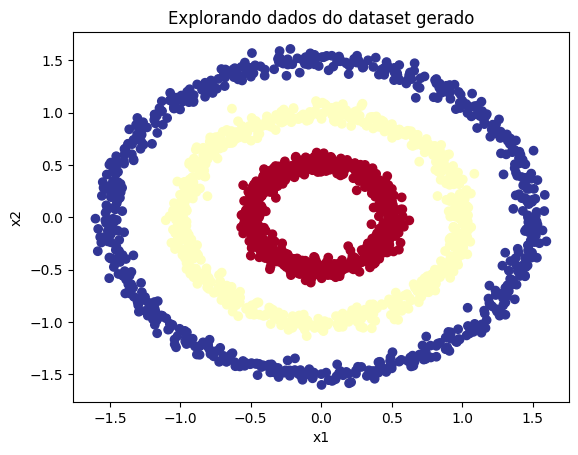

In [350]:
import matplotlib.pyplot as plt

#plt.style.use('default')
#plt.rcParams.update({'font.size': 8})

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c = y, 
            cmap=plt.cm.RdYlBu)
plt.title("Explorando dados do dataset gerado")
plt.xlabel("x1")
plt.ylabel("x2")

Divisão dos dados de treinamento e teste

In [351]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=DEFAULT_SEED)

In [352]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.shape, y_train.shape)

1600 1600
400 400
torch.Size([1600, 3]) torch.Size([1600])


In [353]:
print(X_train[0], y_train[0])
print(X_test[0], y_test[0])

tensor([-0.9740,  0.3108, -0.0170]) tensor(1)
tensor([ 0.3793, -1.5429,  0.0622]) tensor(2)


### Datasets & Dataloaders

In [354]:
from app.datasets import CustomDataset

Transformando dados de treinamento e teste em datasets

In [355]:
train_dataset = CustomDataset(features = X_train, 
                              targets = y_train)

test_dataset = CustomDataset(features = X_test, 
                             targets = y_test)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0], test_dataset[0][1])

1600 400
tensor([-0.9740,  0.3108, -0.0170]) tensor(2)


Parâmetros para criação dos dataloaders, sendo o BATCH_SIZE um hiperparâmetro do treinamento

In [356]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

Definindo dataloaders de treinamento e teste a partir dos datasets

In [357]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              # reordena exemplos a cada época
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False, 
                              num_workers = NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(50, 13)

In [358]:
train_batch_features, train_batch_labels = next(iter(train_dataloader))

print(len(train_batch_features), len(train_batch_labels))
print(train_batch_features[0], train_batch_labels[0])

32 32
tensor([ 0.9545, -0.3893, -0.0304]) tensor(1)


### Arquitetura dos Modelos

In [359]:
from torchinfo import summary

In [360]:
HIDDEN_LAYERS = 4
HIDDEN_UNITS = 5

Modelo base utilizando camadas nn.Linear

In [361]:
from app.models import BaseModel

base_model = BaseModel(input_size=NUM_FEATURES, 
                     hidden_layers=HIDDEN_LAYERS,
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)

summary(base_model, input_size=(1, NUM_FEATURES, ))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [1, 3]                    --
├─Linear: 1-1                            [1, 5]                    20
├─Tanh: 1-2                              [1, 5]                    --
├─Sequential: 1-3                        [1, 5]                    --
│    └─Linear: 2-1                       [1, 5]                    30
│    └─Tanh: 2-2                         [1, 5]                    --
│    └─Linear: 2-3                       [1, 5]                    30
│    └─Tanh: 2-4                         [1, 5]                    --
│    └─Linear: 2-5                       [1, 5]                    30
│    └─Tanh: 2-6                         [1, 5]                    --
│    └─Linear: 2-7                       [1, 5]                    30
│    └─Tanh: 2-8                         [1, 5]                    --
├─Linear: 1-4                            [1, 3]                    18
Total params: 1

Modelo utilizando camadas binet.BitNetLinear

In [362]:
from app.models import BitModel

bit_model = BitModel(input_size=NUM_FEATURES,
                     hidden_layers=HIDDEN_LAYERS, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)

summary(bit_model, input_size=(1, NUM_FEATURES, ))

Layer (type:depth-idx)                   Output Shape              Param #
BitModel                                 [1, 3]                    --
├─BitLinear: 1-1                         [1, 5]                    20
├─Tanh: 1-2                              [1, 5]                    --
├─Sequential: 1-3                        [1, 5]                    --
│    └─BitLinear: 2-1                    [1, 5]                    30
│    └─Tanh: 2-2                         [1, 5]                    --
│    └─BitLinear: 2-3                    [1, 5]                    30
│    └─Tanh: 2-4                         [1, 5]                    --
│    └─BitLinear: 2-5                    [1, 5]                    30
│    └─Tanh: 2-6                         [1, 5]                    --
│    └─BitLinear: 2-7                    [1, 5]                    30
│    └─Tanh: 2-8                         [1, 5]                    --
├─BitLinear: 1-4                         [1, 3]                    18
Total params: 1

### Treinamento dos Modelos

In [363]:
from torchmetrics.classification import Accuracy

from app.engine import train

DEFAULT_ACCURACY = Accuracy(task="multiclass", 
                            num_classes=NUM_CLASSES)

Definição de parâmetros de treinamento

In [364]:
EPOCHS = 10
LEARNING_RATE = 1e-3

Definindo da loss e otimizador para rede BitNet

In [365]:
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=bit_model.parameters(), lr=LEARNING_RATE)

In [366]:
bit_results = train(model = bit_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                metrics=DEFAULT_ACCURACY,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1033, Train Acc: 0.33% | Test Loss: 1.1043, Test Acc: 0.33%
Epoch: 1 | Train Loss: 1.1018, Train Acc: 0.34% | Test Loss: 1.1042, Test Acc: 0.32%
Epoch: 2 | Train Loss: 1.1011, Train Acc: 0.34% | Test Loss: 1.1040, Test Acc: 0.32%
Epoch: 3 | Train Loss: 1.1011, Train Acc: 0.34% | Test Loss: 1.1038, Test Acc: 0.32%
Epoch: 4 | Train Loss: 1.1008, Train Acc: 0.35% | Test Loss: 1.1013, Test Acc: 0.35%
Epoch: 5 | Train Loss: 1.1013, Train Acc: 0.34% | Test Loss: 1.1001, Test Acc: 0.35%
Epoch: 6 | Train Loss: 1.1005, Train Acc: 0.33% | Test Loss: 1.1018, Test Acc: 0.30%
Epoch: 7 | Train Loss: 1.0988, Train Acc: 0.35% | Test Loss: 1.0996, Test Acc: 0.36%
Epoch: 8 | Train Loss: 1.1004, Train Acc: 0.33% | Test Loss: 1.0996, Test Acc: 0.37%
Epoch: 9 | Train Loss: 1.1009, Train Acc: 0.32% | Test Loss: 1.1015, Test Acc: 0.30%


Definindo loss e otimizador para a rede Baseline

In [367]:
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=base_model.parameters(), lr=LEARNING_RATE)

In [368]:
base_results = train(model = base_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                metrics=DEFAULT_ACCURACY,
                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1042, Train Acc: 0.29% | Test Loss: 1.1003, Test Acc: 0.36%
Epoch: 1 | Train Loss: 1.0964, Train Acc: 0.39% | Test Loss: 1.0958, Test Acc: 0.37%
Epoch: 2 | Train Loss: 1.0937, Train Acc: 0.40% | Test Loss: 1.0894, Test Acc: 0.42%
Epoch: 3 | Train Loss: 1.0891, Train Acc: 0.40% | Test Loss: 1.0816, Test Acc: 0.42%
Epoch: 4 | Train Loss: 1.0806, Train Acc: 0.41% | Test Loss: 1.0653, Test Acc: 0.47%
Epoch: 5 | Train Loss: 1.0679, Train Acc: 0.42% | Test Loss: 1.0473, Test Acc: 0.50%
Epoch: 6 | Train Loss: 1.0548, Train Acc: 0.44% | Test Loss: 1.0337, Test Acc: 0.50%
Epoch: 7 | Train Loss: 1.0447, Train Acc: 0.44% | Test Loss: 1.0220, Test Acc: 0.50%
Epoch: 8 | Train Loss: 1.0361, Train Acc: 0.46% | Test Loss: 1.0146, Test Acc: 0.49%
Epoch: 9 | Train Loss: 1.0289, Train Acc: 0.45% | Test Loss: 1.0089, Test Acc: 0.50%


### Resultados do Experimento

In [369]:
from app.utils import plot_results

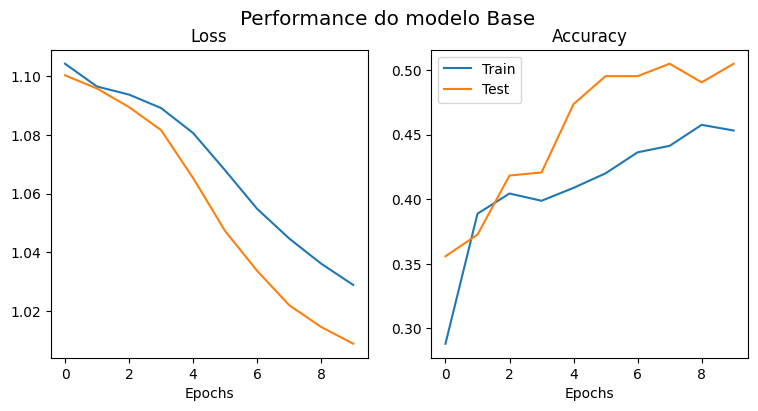

In [370]:
# exibindo performance do modelo base
plot_results(results = base_results)

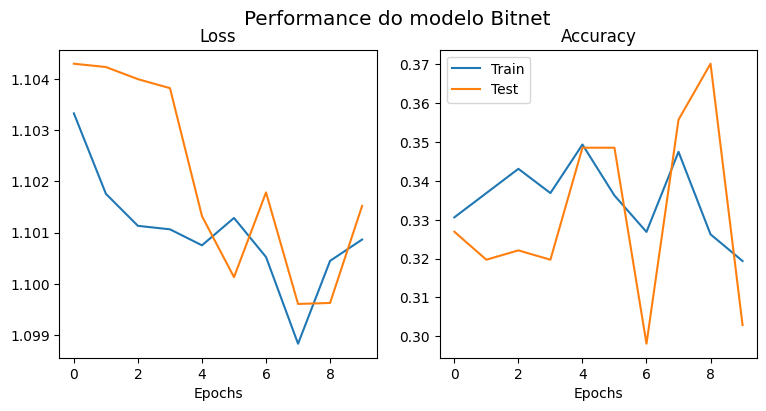

In [371]:
# exibindo performance do modelo bitnet
plot_results(results = bit_results)

Baixando funções auxiliares para visualização das regiões de separação dos modelos

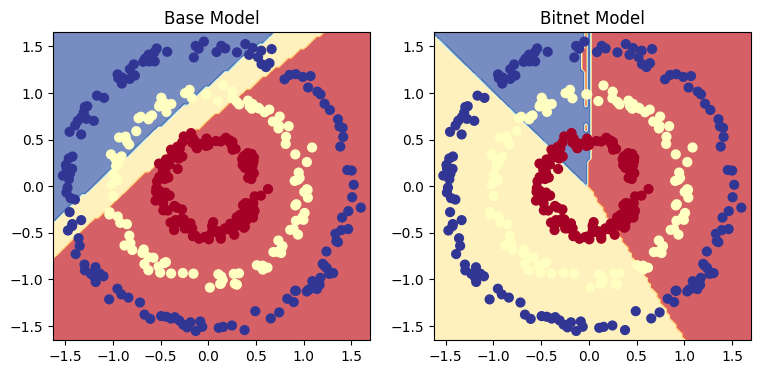

In [372]:
from app.utils import plot_decision_boundary

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"{base_model.name} Model")
plot_decision_boundary(base_model, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title(f"{bit_model.name} Model")
plot_decision_boundary(bit_model, X_test, y_test)

### Tamanho do Modelo

Salvando modelos localmente

In [373]:
from pathlib import Path

target_dir_path = Path("./models")

# criando diretório caso não exista
target_dir_path.mkdir(parents=True,
                      exist_ok=True)

base_model_path = target_dir_path / "base_model.pt"

bit_model_path = target_dir_path / "bit_model.pt"

torch.save(obj = base_model.state_dict(), 
           f = base_model_path)

torch.save(obj = bit_model.state_dict(), 
           f = bit_model_path)

Recuperando tamanho dos arquivos gerados

In [374]:
weight_size_base_model = base_model_path.stat().st_size
weight_size_bit_model = bit_model_path.stat().st_size

print(f"base_model.state_dict: {weight_size_base_model}")
print(f"bit_model.state_dict: {weight_size_bit_model}")
print(f"Proporção bit/base: {weight_size_bit_model/weight_size_base_model:.2f}")

base_model.state_dict: 4834
bit_model.state_dict: 4818
Proporção bit/base: 1.00
